<font color="green">**LSTM model for stock prediction using stock data only**</font>

**Import Libraries**

In [ ]:
#Import the libraries
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

**Get stock data and visualize**

In [ ]:
#Get the stock quote 
df = web.DataReader('AMD', data_source='yahoo', start='2016-07-22', end='2020-05-26')

#To get stock quote for other companies like Apple, Disney, Tesla=>Uncomment required line below
#df = web.DataReader('AAPL', data_source='yahoo', start='2016-07-22', end='2020-10-30')
#df = web.DataReader('DIS', data_source='yahoo', start='2016-07-22', end='2020-10-30')
#df = web.DataReader('TSLA', data_source='yahoo', start='2016-07-22', end='2020-10-30')

#Show the data 
df.head(5)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2016-07-22,33.459999,32.470001,32.900002,32.869999,1637000,32.869999
2016-07-25,33.099998,32.500000,32.959999,32.599998,540600,32.599998
2016-07-26,32.730000,31.830000,32.540001,32.549999,802000,32.549999
2016-07-27,33.520000,32.790001,32.980000,33.209999,856900,33.209999
2016-07-28,34.570000,33.430000,33.509998,34.270000,1046900,34.270000


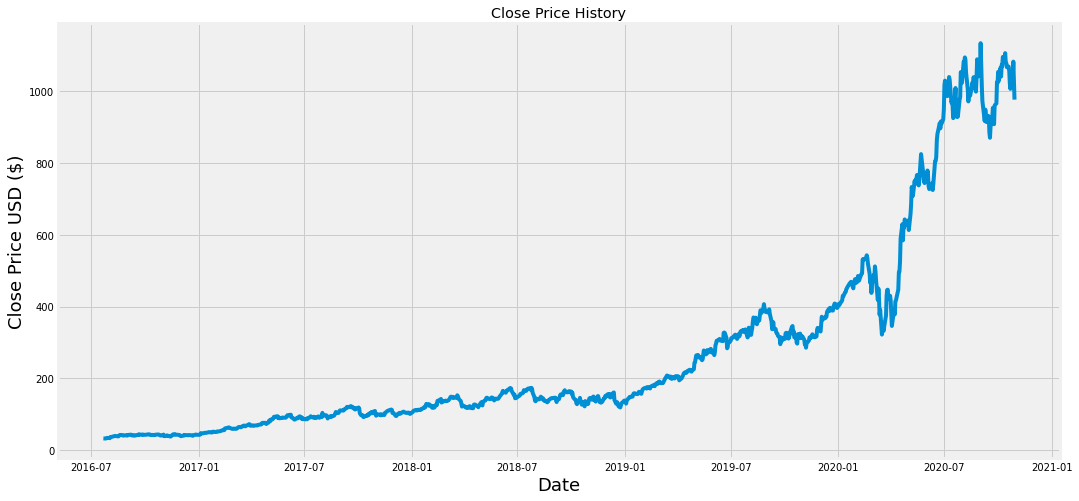

In [ ]:
#Visualize the closing price history
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD ($)',fontsize=18)
plt.show()

**Preprocess data and split into train-test datasets**

In [ ]:
#Create a new dataframe with only the 'Close' column
data = df.filter(['Close'])
#Converting the dataframe to a numpy array
dataset = data.values
#Get /Compute the number of rows to train the model on
training_data_len = math.ceil( len(dataset) *.8)

In [ ]:
#Scale the all of the data to be values between 0 and 1 
scaler = MinMaxScaler(feature_range=(0, 1)) 
scaled_data = scaler.fit_transform(dataset)

In [ ]:
scaled_data[1]

array([4.53808322e-05])

In [ ]:
#Create the scaled training data set 
train_data = scaled_data[0:training_data_len  , : ]
#train_data = dataset[0:training_data_len  , : ]
#Split the data into x_train and y_train data sets
x_train=[]
y_train = []
for i in range(60,len(train_data)):
  x_train.append(train_data[i-60:i,0])
  y_train.append(train_data[i,0])

In [ ]:
y_train[1]

0.00901277107053556

In [ ]:
#Convert x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [ ]:
#Test data set
#scaled_data = scaler.fit_transform(dataset)
test_data = scaled_data[training_data_len - 60: , : ]
#data = df.filter(['Close'])
#Converting the dataframe to a numpy array
#dataset = data.values
#test_data = dataset[training_data_len - 60: , : ]
#test_data = scaler.fit_transform(test_data)
#Create the x_test and y_test data sets
x_test = []
y_test =  dataset[training_data_len : , : ] #Get all of the rows from index 1603 to the rest and all of the columns (in this case it's only column 'Close'), so 2003 - 1603 = 400 rows of data
for i in range(60,len(test_data)):
  x_test.append(test_data[i-60:i,0])

In [ ]:
#Convert x_test to a numpy array 
x_test = np.array(x_test)

**Build model and train using training data**

In [ ]:
#Build the LSTM network model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

In [ ]:
#Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')
#model.compile(optimizer='adam',loss='mean_absolute_error')

In [ ]:
#Reshape the data into the shape accepted by the LSTM
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In [ ]:
#Train the model
#model.fit(x_train, y_train, batch_size=1, epochs=1)
model.fit(x_train,  y_train, batch_size=1, epochs=1)

802/802 [==============================] - 17s 22ms/step - loss: 5.3817e-04


In [ ]:
#Reshape the data into the shape accepted by the LSTM
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

**Predict on testing data and visualize predictions**

In [ ]:
#Getting the models predicted price values
predictions = model.predict(x_test) 
preds=predictions
predictions = scaler.inverse_transform(predictions)#Undo scaling

In [ ]:
print(predictions[0])

[393.7037]


In [ ]:
#Calculate/Get the value of RMSE
rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
rmse

60.303013819585125

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


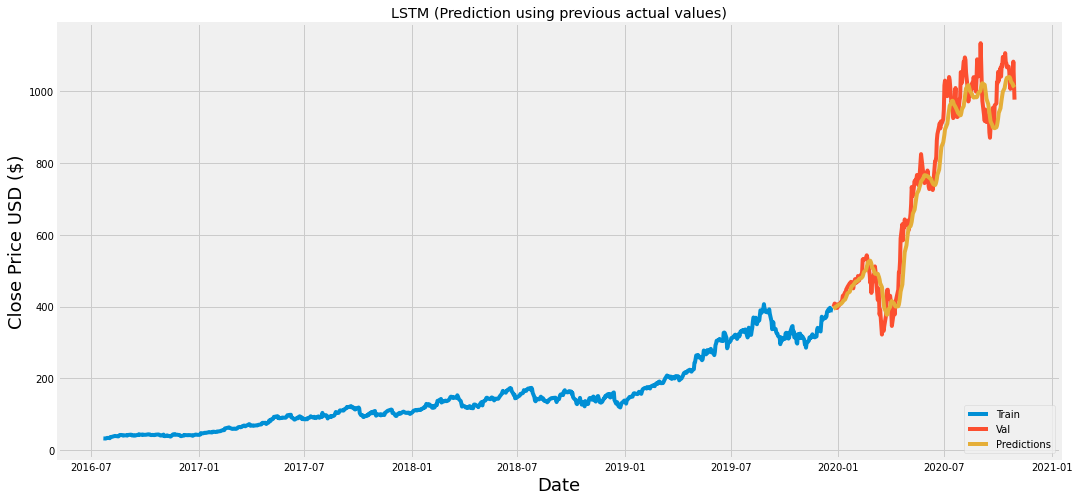

In [ ]:
#Plot/Create the data for the graph
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
#Visualize the data
plt.figure(figsize=(16,8))
plt.title('LSTM (Prediction using previous actual values)')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

<font color="green">**Predict future data using predicted values**</font>

In [ ]:
#Make predictions for 2 days ahead using predicted value of 1 day ahead
newpredictions=[]
newXTest=x_test[0]
for i in range(0,len(x_test)):
  newXTest = np.reshape(newXTest, (1,x_test.shape[1], 1))
  newpred = model.predict(newXTest)
  newpredictions=np.append(newpredictions,newpred)
  for j in range(0,len(newXTest)-1):
    newXTest[j]=newXTest[j+1]
  newXTest[len(newXTest)-1]=newpred 
newpredictions = np.reshape(newpredictions, (x_test.shape[0],1))
new_predictions = scaler.inverse_transform(newpredictions)#Undo scaling

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


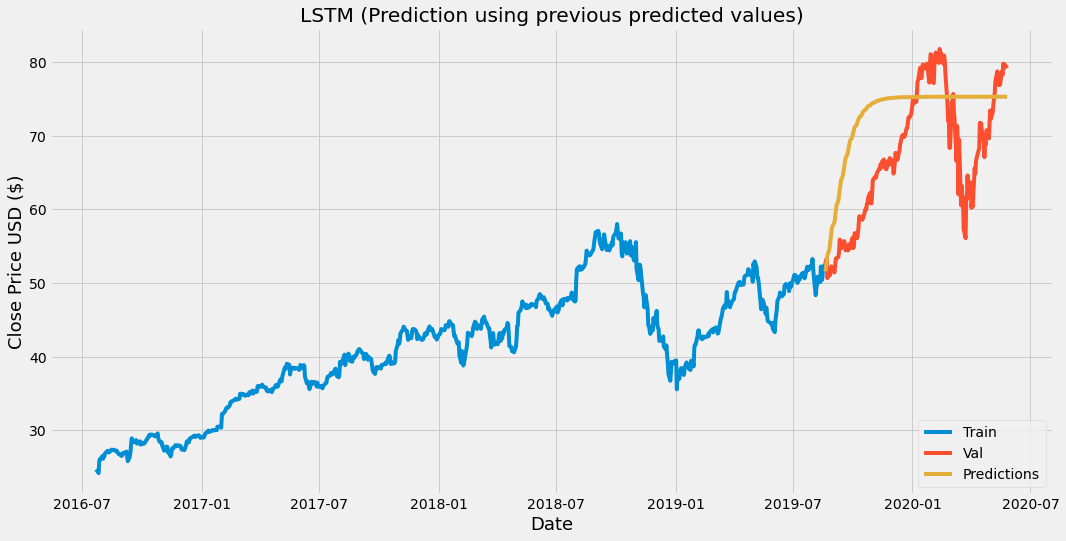

In [ ]:
#Plot/Create the data for the graph
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = new_predictions
#Visualize the data
plt.figure(figsize=(16,8))
plt.title('LSTM (Prediction using previous predicted values)')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

<font color="green">**Drift detection**</font>

In [ ]:
#mean absolute error
from sklearn.metrics import mean_absolute_error
mae=mean_absolute_error(y_test, predictions)
mae

1.8345663831641636

**Find data that shows drift and visualize drift**

In [ ]:
#Find drift data
df1=df.reset_index()
datelist=[]
for i in range(len(y_test)):
  diff=abs(y_test[i]-predictions[i])
  if(diff>(mae+2.5)):
    #print(df1.loc[training_data_len+i,"Date"])
    datelist.append(df1.loc[training_data_len+i,"Date"])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


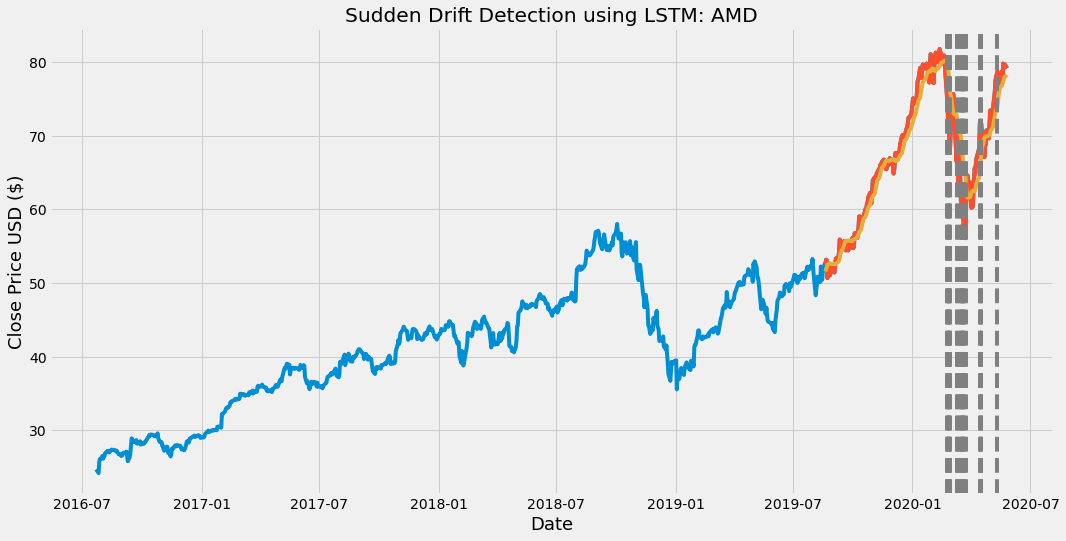

In [ ]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
#Visualize the closing price history
plt.figure(figsize=(16,8))
plt.title('Sudden Drift Detection using LSTM: AMD')
plt.plot(df1['Date'],df1['Close'])
plt.plot(valid[['Close', 'Predictions']])
for i in range(len(datelist)):
  plt.axvline(pd.Timestamp(datelist[i]),color='gray',linestyle='--')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD ($)',fontsize=18)
plt.show()

<font color="green">**Drift detection for training data**</font>

**Create predictions on training data and visualize**

In [ ]:
#Predict on training data
train_predictions = model.predict(x_train) 
train_preds=train_predictions
train_predictions = scaler.inverse_transform(train_predictions)#Undo scaling

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


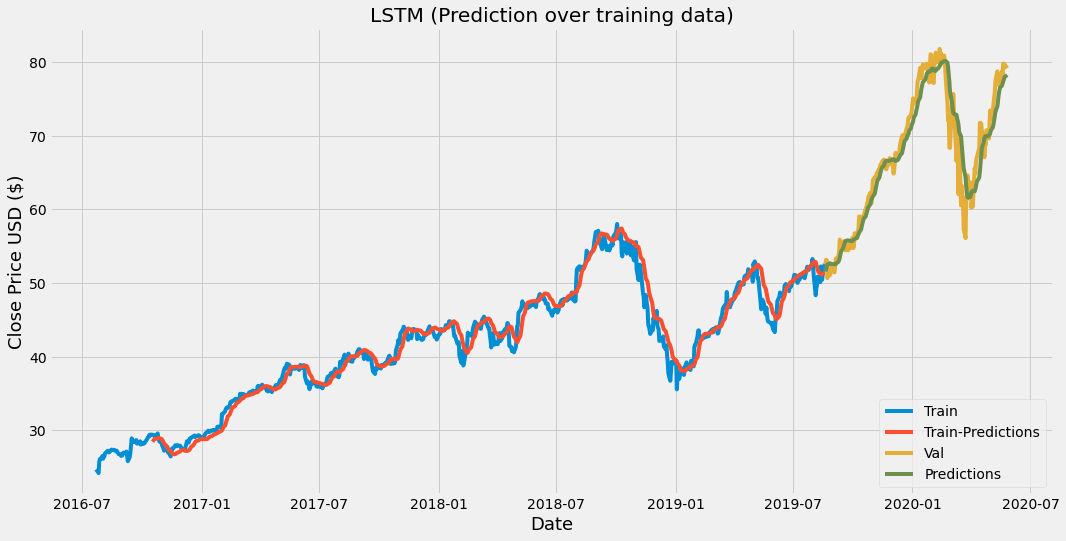

In [ ]:
#Plot/Create the data for the graph
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
x = data[60:training_data_len]
x['Train_Predictions'] = train_predictions
#Visualize the data
plt.figure(figsize=(16,8))
plt.title('LSTM (Prediction over training data)')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(x['Train_Predictions'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train','Train-Predictions', 'Val', 'Predictions'], loc='lower right')
plt.show()

**Find data that shows drift in training data**

In [ ]:
#mean absolute error
from sklearn.metrics import mean_absolute_error
train_mae=mean_absolute_error(y_train, train_predictions)
train_mae

42.24004788106541

In [ ]:
#Find drift data
for i in range(len(y_train)):
  diff=abs(y_train[i]-train_predictions[i])
  if(diff>(train_mae+5)):
    #print(df1.loc[training_data_len+i,"Date"])
    datelist.append(df1.loc[60+i,"Date"])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


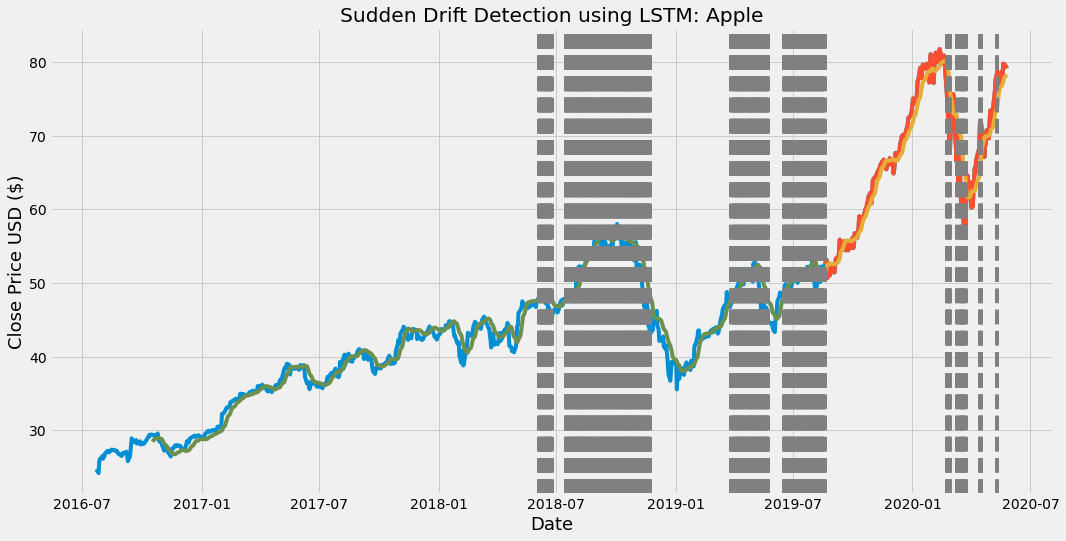

In [ ]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
x = data[60:training_data_len]
x['Train_Predictions'] = train_predictions
#Visualize the closing price history
plt.figure(figsize=(16,8))
plt.title('Sudden Drift Detection using LSTM: Apple')
plt.plot(df1['Date'],df1['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.plot(x['Train_Predictions'])
for i in range(len(datelist)):
  plt.axvline(pd.Timestamp(datelist[i]),color='gray',linestyle='--')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD ($)',fontsize=18)
plt.show()